<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/Copy__new_exp_(W)_of_signal_kalman_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
!pip install pykalman -q
!pip install yfinance -q
!pip install pandas-ta==0.2.45b -q

In [110]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pyplot import figure

sns.set(style='darkgrid')

In [111]:
pd.options.mode.chained_assignment = None

In [112]:
#ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_niftybanklist.csv')

In [113]:
ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv')
START = "2013-01-01"

In [114]:
nifty=yf.download('^nsei',start=START)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [61]:
lst=[]
for i in range(len(ticker)):
  
  dfi = yf.download(str(ticker.Symbol.iloc[i])+'.ns', start=START)
  df = dfi[['Adj Close']]
  f = KalmanFilter(transition_matrices = [1],
                    observation_matrices = [1],
                    initial_state_mean = 0,
                    initial_state_covariance = 1,
                    observation_covariance = 1,
                    transition_covariance = 0.0001)
  mean, cov = f.filter(df['Adj Close'].values)
  mean, std = mean.squeeze(), np.std(cov.squeeze())
  var = 'kalman'
  df[var]=df['Adj Close'].values - mean
  
  lst.append(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [62]:
nlst=[]
for i in range(len(ticker)):
  nlst.append(lst[i].kalman)  

In [63]:
df_kalman = pd.DataFrame(nlst).T

In [64]:
namelist =[]
for i in range(1,len(ticker)+1):
  namelist.append('kalman_'+str(i))
  
df_kalman.columns = namelist

In [65]:
def macd_calc(df):
  columns=df.columns.tolist()
  for var in columns:
    macd='macd'+var
    macd_s='macd'+'signal'+var
    macd_h='hist'+ var
    df[macd]=df[var].ewm(span=26, adjust=False).mean()-df[var].ewm(span=50, adjust=False).mean()
    df[macd_s]=df[macd].ewm(span=18,adjust=False).mean()
    df[macd_h]=df[macd]-df[macd_s]
  return df

In [66]:
final_kalman=macd_calc(df_kalman)

<ipython-input-65-8e9a62eff4af>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[macd]=df[var].ewm(span=26, adjust=False).mean()-df[var].ewm(span=50, adjust=False).mean()
<ipython-input-65-8e9a62eff4af>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[macd_s]=df[macd].ewm(span=18,adjust=False).mean()
<ipython-input-65-8e9a62eff4af>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

In [67]:
final_kalman.tail(2)

,kalman_1,kalman_2,kalman_3,kalman_4,kalman_5,kalman_6,kalman_7,kalman_8,kalman_9,kalman_10,...,histkalman_47,macdkalman_48,macdsignalkalman_48,histkalman_48,macdkalman_49,macdsignalkalman_49,histkalman_49,macdkalman_50,macdsignalkalman_50,histkalman_50
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-14,93.980690,8.716201,161.203779,-21.60303,-138.397685,58.742349,17.758184,80.207399,671.142217,77.703593,...,-12.347759,13.370265,12.870690,0.499575,145.093167,129.168854,15.924313,8.213051,7.252248,0.960804
2022-12-15,76.610766,-6.567647,155.392069,-53.81221,-166.524388,40.188426,17.977502,76.587647,719.659549,66.138986,...,-13.812192,12.794139,12.862632,-0.068493,141.034059,130.417823,10.616236,7.970054,7.327806,0.642248


In [68]:
features = final_kalman.columns.tolist()

In [69]:
feats_set1=[feats for feats in features if feats.startswith('hist')]

In [70]:
final_dataframe=final_kalman[feats_set1]

In [71]:
solution=np.sign(final_dataframe)

In [72]:
solution['final']=solution.sum(axis=1)

In [73]:
solution.tail(2)

,histkalman_1,histkalman_2,histkalman_3,histkalman_4,histkalman_5,histkalman_6,histkalman_7,histkalman_8,histkalman_9,histkalman_10,...,histkalman_42,histkalman_43,histkalman_44,histkalman_45,histkalman_46,histkalman_47,histkalman_48,histkalman_49,histkalman_50,final
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-14,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,...,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,6.0
2022-12-15,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,...,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-2.0


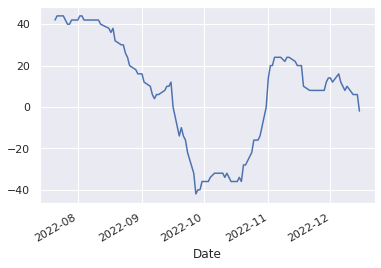

In [74]:
solution.final[-100:].plot();

In [75]:
solution['avg_mov_1']=solution['final'].rolling(window=15).mean()

nifty['avg_mov']=nifty['Adj Close'].rolling(window=22).mean()

In [76]:
l=1300

In [77]:
nifty['spread']=nifty['Close']-nifty['avg_mov']

In [78]:
nifty.head(2)

,Open,High,Low,Close,Adj Close,Volume,avg_mov,spread
Date,,,,,,,,
2013-01-02,5982.600098,6006.049805,5982.000000,5993.25,5993.25,0,NaN,NaN
2013-01-03,6015.799805,6017.000000,5986.549805,6009.50,6009.50,0,NaN,NaN


In [79]:
nifty=nifty[-l:]
solution=solution[-l:]

In [80]:
nifty.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'avg_mov',
       'spread'],
      dtype='object')

In [81]:
df=pd.concat([nifty ,solution[['final','avg_mov_1']]],axis=1)


In [82]:
np.sign(df['spread']).value_counts()

 1.0    833
-1.0    467
Name: spread, dtype: int64

In [83]:
df['Up Trend'] = np.where((np.sign(df['spread'])==1) & (np.sign(df['final']-df['avg_mov_1'])==1),1,0)

In [84]:
df['Down Trend'] = np.where((np.sign(df['spread'])==-1) & (np.sign(df['final']-df['avg_mov_1'])==-1),-1,0)

In [85]:
df['signal_final']=df['Up Trend']+df['Down Trend']

In [86]:
df.signal_final.value_counts()

 1    493
 0    459
-1    352
Name: signal_final, dtype: int64

In [87]:
df=df[-300:]

In [88]:
df=df.reset_index()

In [89]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'avg_mov', 'spread', 'final', 'avg_mov_1', 'Up Trend', 'Down Trend',
       'signal_final'],
      dtype='object')

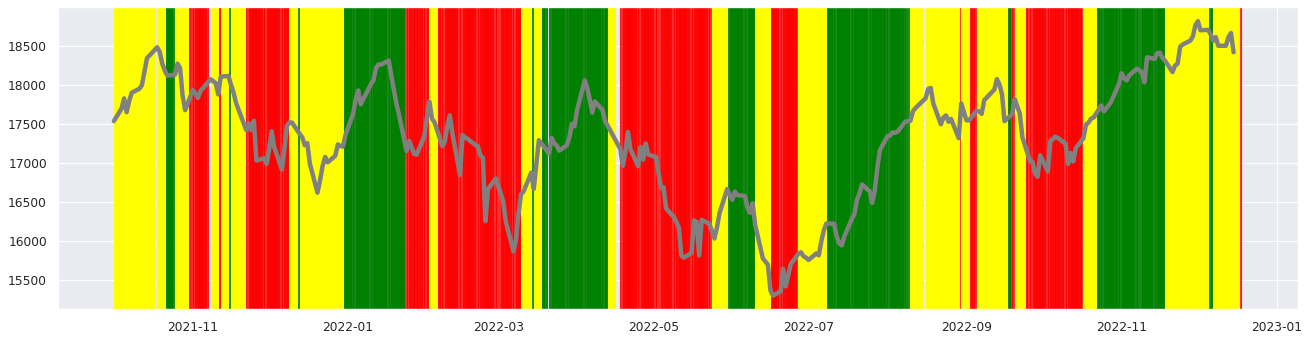

In [90]:
import datetime
df["Regime"] = df['signal_final']
figure(figsize=(20,5), dpi=80)

#plot command, save object in variable
plt.plot(df["Date"], (df.Close.values),color='grey',linewidth=4)
#plt.plot(df.close)
#filter out recession dates
recessions = df.loc[df["Regime"] == -1, 'Date']
nonrecession = df.loc[df['Regime']==1,'Date']
neodata= df.loc[df['Regime']==0,'Date']
#plot axvspan for every recession day
for day in recessions:
    
    plt.axvspan(day, day + datetime.timedelta(days=3), color="red", alpha=0.8)
for day in nonrecession:
    plt.axvspan(day, day + datetime.timedelta(days=3), color="green", alpha=0.9)
for day in neodata:
    plt.axvspan(day, day + datetime.timedelta(days=3), color="yellow", alpha=1)      
plt.show()

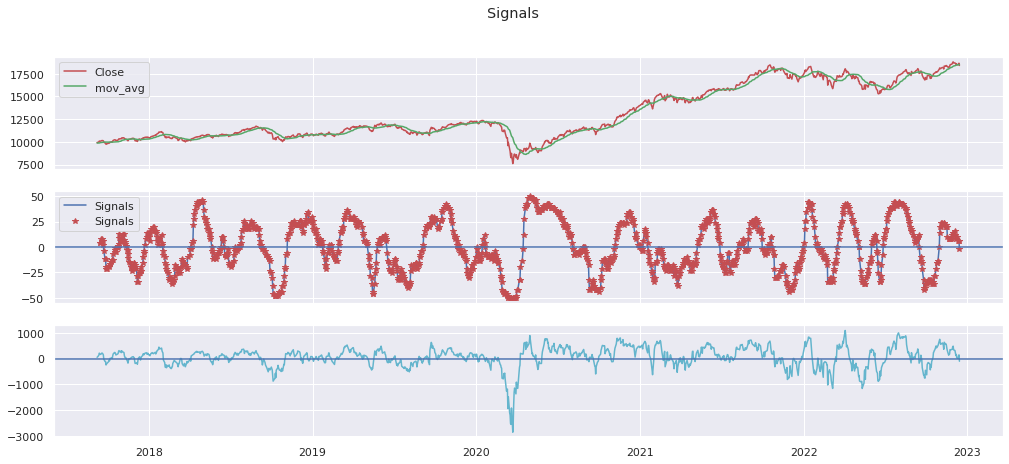

In [91]:
fig, ax = plt.subplots(3,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'avg_mov'],'g', label='mov_avg')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'b', label='Signals')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'r*', label='Signals')
ax[2].plot(nifty.loc[:, :].index,nifty.loc[:,'spread'],'c',label='Spread')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[1].axhline(y=0)
ax[2].axhline(y=0)
plt.show()

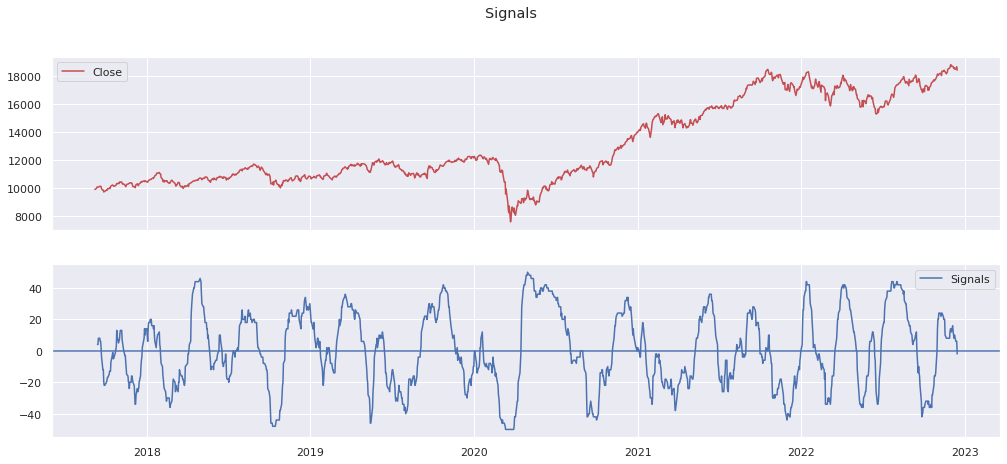

In [92]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'b', label='Signals')
#ax[1].plot(solution.iloc[:, :].index, solution.loc[:, 'avg_mov'], label='Moving_Average')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
plt.show()

In [93]:
new=pd.DataFrame()

In [94]:
new['signal_high'] = np.where((nifty['Close']>nifty['avg_mov']) & (solution['final']>solution['avg_mov_1']),1,0)

In [95]:
new['signal_low'] = np.where((nifty['Close']<nifty['avg_mov']) & (solution['final']<solution['avg_mov_1']),-1,0)

In [96]:
new['signal_final']=new['signal_high']+new['signal_low']

In [97]:
#pd.concat([solution.reset_index(),new[-4:]],axis=0)

In [98]:
l=1400

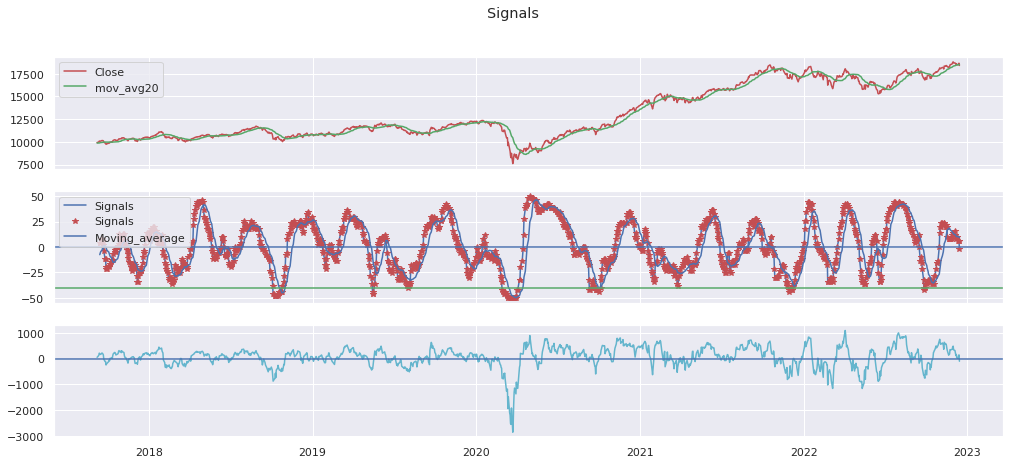

In [99]:
fig, ax = plt.subplots(3,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'Close'][-l:],'r', label='Close')
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'avg_mov'][-l:],'g', label='mov_avg20')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:], label='Signals')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:],'r*', label='Signals')
ax[1].plot(solution.iloc[:, :].index[-l:], solution.loc[:, 'avg_mov_1'][-l:],'b',label='Moving_average')
ax[2].plot(nifty.loc[:, :].index[-l:],nifty.loc[:,'spread'][-l:],'c',label='Spread')
#ax[3].plot(new.loc[:,:].index[-l:],new.loc[:,'signal_final'][-l:])
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend(loc='upper left')
ax[1].axhline(y=0)
ax[2].axhline(y=0)
ax[1].axhline(y=-40,color='g')
plt.show()

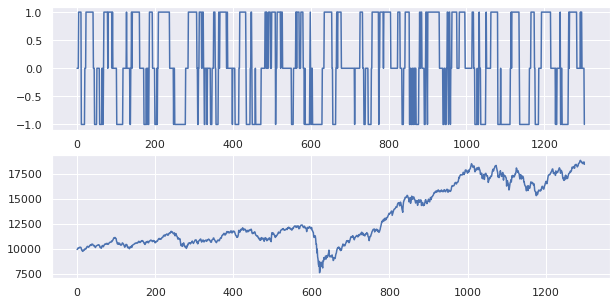

In [100]:
fig, ax = plt.subplots(2,1,figsize=(10,5),sharex=False)
ax[0].plot(new['signal_final'][-l:])
ax[1].plot(nifty['Close'][-l:].values)
plt.show()

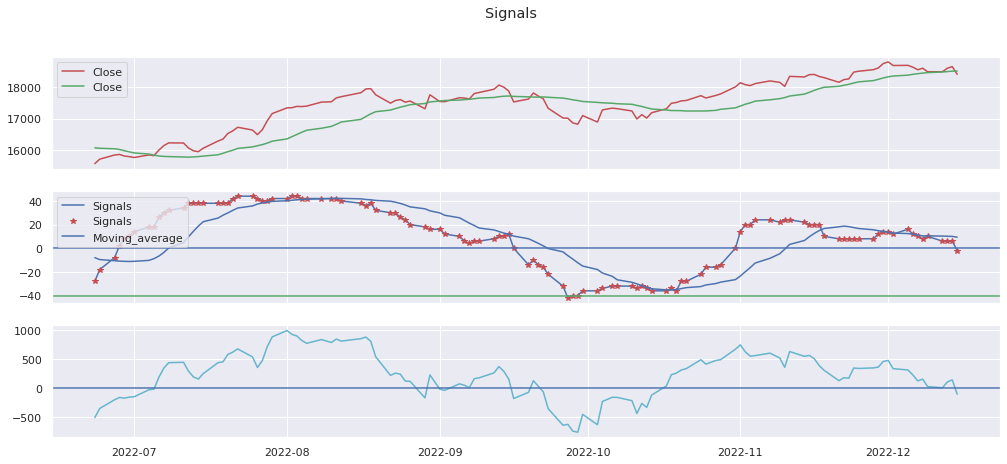

In [101]:
l=120
fig, ax = plt.subplots(3,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'Close'][-l:],'r', label='Close')
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'avg_mov'][-l:],'g', label='Close')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:], label='Signals')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:],'r*', label='Signals')
ax[1].plot(solution.iloc[:, :].index[-l:], solution.loc[:, 'avg_mov_1'][-l:],'b',label='Moving_average')
ax[2].plot(nifty.loc[:, :].index[-l:],nifty.loc[:,'spread'][-l:],'c',label='Spread')

plt.suptitle('Signals')
ax[0].legend()
ax[1].legend(loc='upper left')
ax[1].axhline(y=0)
ax[2].axhline(y=0)
ax[1].axhline(y=-40,color='g')
plt.show()

In [102]:
solution['signals']=np.where(solution['final']>0,1,-1)

In [103]:
if solution['signals'].iloc[-1]!=solution['signals'].iloc[-2]:
  var= solution['signals'].iloc[-1]
  print(f'signal changed to : {var}')
else :
  var= solution['signals'].iloc[-1]
  print(f'signal unchanged (1:stay long , -1: stay short) : {var}')

signal changed to : -1


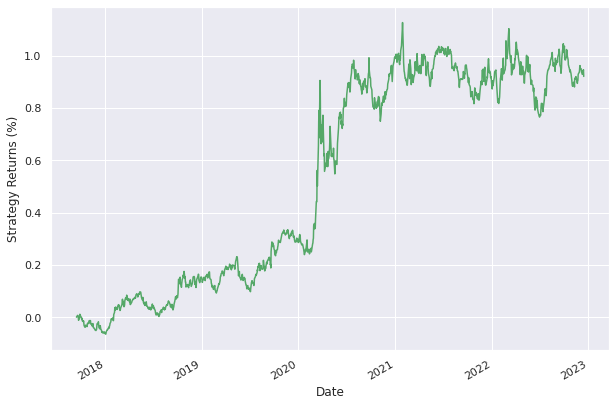

sharpe ratio :  0.07617794410843039
sortino ratio :  1.8051621072346928


In [104]:
# Calculate daily returns
nifty['Return'] = nifty.Close.pct_change()
 
# Calculate strategy returns
nifty['Strategy_F'] = nifty.Return * solution.signals.shift(1)

# Calculate geometric returns
geometric_returns = ((nifty.Strategy_F+1).cumprod()-1)
#np.sum(np.log(data/data.shift())*portfolio, axis=1)
# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
volatility = geometric_returns.std() * np.sqrt(252)
sharpe_ratio = (geometric_returns.mean() - 0.05) / volatility 
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()
print('sharpe ratio : ' ,sharpe_ratio)

std_neg = geometric_returns[geometric_returns<0].std()*np.sqrt(252)
sortino_ratio=(geometric_returns.mean() - 0.05)/std_neg
print('sortino ratio : ' , sortino_ratio)

In [105]:
def max_drawdown(return_series):
    comp_ret =return_series
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()
geometric_returns=pd.DataFrame(geometric_returns)

max_drawdowns= geometric_returns.apply(max_drawdown)
print('max_drawdown : ' , max_drawdowns)

max_drawdown :  Strategy_F   -6.576172
dtype: float64


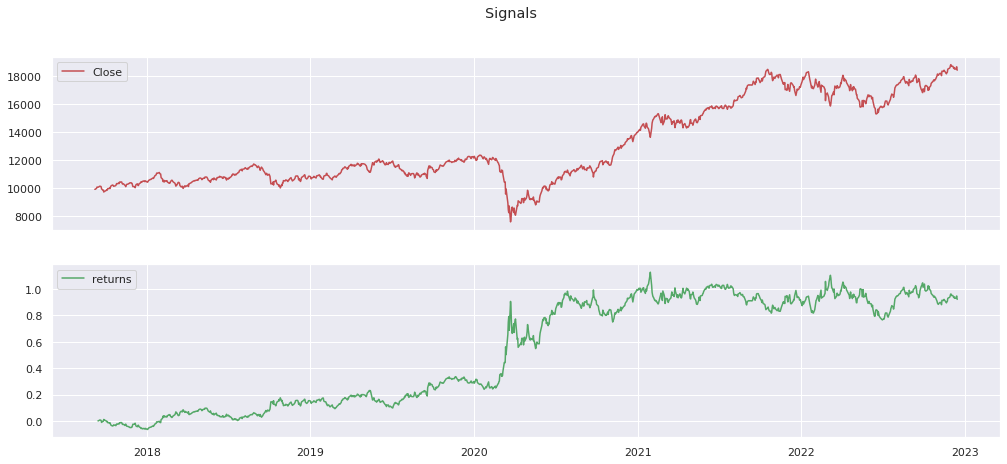

In [106]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[1].plot(geometric_returns.index,geometric_returns,'g', label='returns')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
plt.show()

In [107]:
nifty.tail(2)

,Open,High,Low,Close,Adj Close,Volume,avg_mov,spread,Return,Strategy_F
Date,,,,,,,,,,
2022-12-14,18671.250000,18696.099609,18632.900391,18660.300781,18660.300781,208000,18516.195490,144.105291,0.002811,0.002811
2022-12-15,18614.400391,18652.900391,18387.699219,18414.900391,18414.900391,0,18516.718217,-101.817827,-0.013151,-0.013151


In [108]:
print('change in nifty from yesterday' ,(nifty.Close.iloc[-1]-nifty.Close.iloc[-2])/nifty.Close.iloc[-2]*100)

change in nifty from yesterday -1.315093435533365
